## GEBCO 2024 Bathymetry

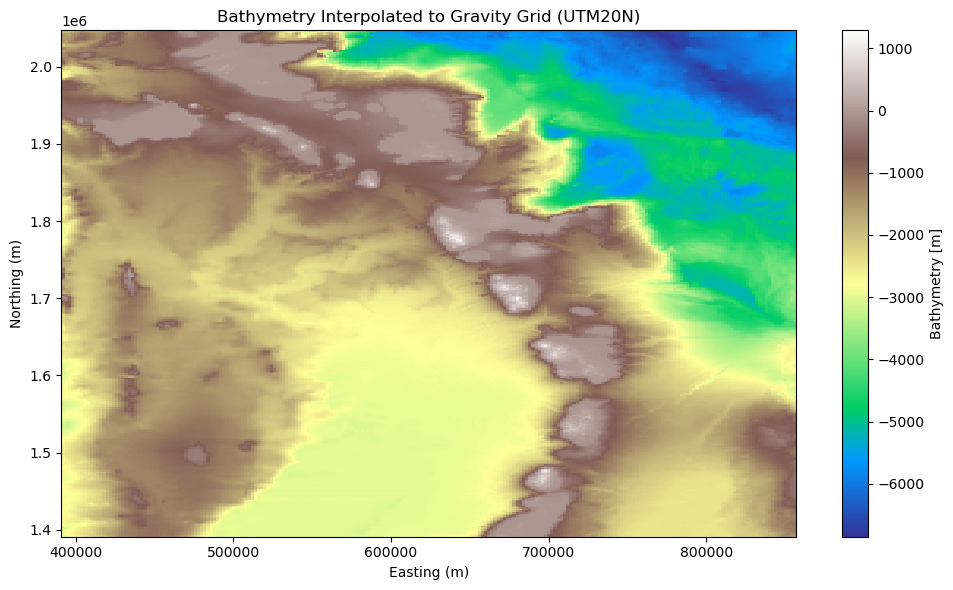

In [1]:
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
from pyproj import Transformer
import matplotlib.pyplot as plt

# --- STEP 1: Load and crop GEBCO data (in lat/lon) ---
lon_min, lon_max = -64.5, -59.0
lat_min, lat_max = 12.0, 19.0

ds = xr.open_dataset("gebco_2024.nc")
ds_sub = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lats = ds_sub['lat'].values
lons = ds_sub['lon'].values
elev = ds_sub['elevation'].values

# If needed, flip lat dimension
if np.any(np.diff(lats) < 0):
    lats = lats[::-1]
    elev = elev[::-1, :]

# --- STEP 2: Project GEBCO lat/lon grid to UTM20N ---
lon_grid, lat_grid = np.meshgrid(lons, lats)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32620", always_xy=True)
x_grid, y_grid = transformer.transform(lon_grid, lat_grid)

# Flatten to (N, 2) points
points_src = np.column_stack((x_grid.ravel(), y_grid.ravel()))
elev_values = elev.ravel()

# --- STEP 3: Load gravity grid (already in UTM) ---
gravity_file = "gravity interpolated grid/interpolated_gravity_noOBS_NEW.xyz"
gravity_data = np.loadtxt(gravity_file, skiprows=1)

x_flat = gravity_data[:, 0]
y_flat = gravity_data[:, 1]

x_unique = np.unique(x_flat)
y_unique = np.unique(y_flat)
nx = len(x_unique)
ny = len(y_unique)

xi = x_flat.reshape((ny, nx))
yi = y_flat.reshape((ny, nx))

# --- STEP 4: Interpolate using griddata ---
points_target = np.column_stack((x_flat, y_flat))
bathy_interp_values = griddata(points_src, elev_values, points_target, method='linear')
bathy_interp_grid = bathy_interp_values.reshape((ny, nx))

# --- STEP 5: Save and plot ---
n_points = xi.size
index_col = np.arange(1, n_points + 1)

np.savetxt(
    "bathy_full_with_index.xyz",
    np.column_stack((xi.ravel(), yi.ravel(), bathy_interp_grid.ravel(), index_col)),
    fmt="%.3f %.3f %.3f %d",
    delimiter=" ",
    header="X Y Bathymetry Index",
    comments=""
)

plt.figure(figsize=(10, 6))
plt.pcolormesh(xi, yi, bathy_interp_grid, shading='auto', cmap='terrain')
plt.colorbar(label='Bathymetry [m]')
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.title("Bathymetry Interpolated to Gravity Grid (UTM20N)")
plt.tight_layout()
plt.show()


## Interpolating shipborne bathymetry (Ifremer + GEOMAR)